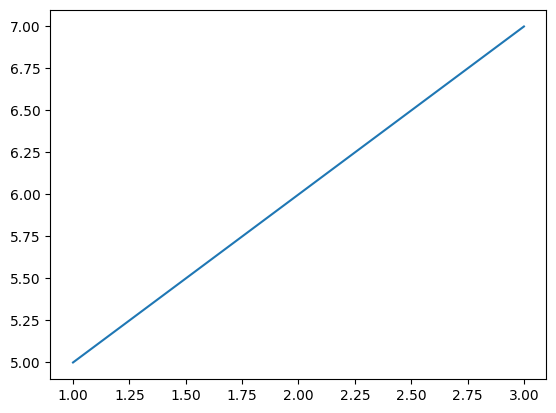

2451431.5208333335
(7, 23, 0.5)
(6, 8, 38.400000000001455)
[[ 0.99923861  0.01744177 -0.0348995 ]
 [-0.01560227  0.99850932  0.05230407]
 [ 0.03575975 -0.05171974  0.9980212 ]]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 3 dimensions. The detected shape was (2, 3, 3) + inhomogeneous part.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import astrotools as at

x = np.array([1,2,3])
y = np.array([5,6,7])

plt.plot(x,y)
plt.show()
print(at.CalUTtoJD(1999,9,10,.5))
print(at.dayOfYearToMonthDay(2024, 205.5))
print(at.fracDaytoHMS(0.256))
R = at.rot(45,3,"deg")
# print(R)

# print(np.dot(R,x))
R2, _ = at.EAtoDCM(np.array([1,2,3]),np.array([3,2,1]),"degrees")
print(R2)
obj = {
    "SemimajorAxis": 6.796593878694531e+03,
    "Eccentricity": 7.373000000000000e-04,
    "Inclination": 51.638800000000003,
    "RAAN": 2.005949000000000e+02,
    "AOP": 17.026399999999999,
    "TrueAnomaly": 83.057698617457802}

earth = at.MyWGS84("km")

print(at.COEtoRV(obj["SemimajorAxis"],
                 obj["Eccentricity"],
                 obj["Inclination"],
                 obj["RAAN"],
                 obj["AOP"],
                 obj["TrueAnomaly"],
                 earth.mu))